# AMAL // Prise en main de PyTorch
                        notebook n°2 sur 3

Cette séance est dédiée à l'utilisation d'`Autograd` et à nos premiers pas avec les `Modules`.

Toujours plus de sources :  
https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html  
https://discuss.pytorch.org/t/difference-between-detach-clone-and-clone-detach/34173  
https://pytorch.org/tutorials/beginner/nn_tutorial.html  
https://nn.readthedocs.io/en/rtd/containers/index.html  
https://pytorch.org/docs/stable/nn.init.html  
https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

In [11]:
# //////////////////////////////////////////////////////////////////////////////////////// <importing libraries> ////

# Ne pas oublier d'executer dans le shell avant de lancer python :
# source /users/Enseignants/piwowarski/venv/amal/3.7/bin/activate

import datamaestro
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import random
import numpy as np
import math
from tqdm.auto import tqdm

# Output formatting
fred = "\033[91m"
fgrn = "\033[92m"
fbld = "\033[1m"
fend = "\033[0m"

# /////////////////////////////////////////////////////////////////////////////////////// </importing libraries> ////

### Table des matières

<a href="#atgd">Découverte d'Autograd</a>  
<a href="#prep">Préparation des tâches</a>  
&nbsp;&nbsp;Récupération des données // Types de descente // Généralités sur les paramètres // Initialisation Xavier  
<a href="#auto">Descente de gradient automatique</a>   
&nbsp;&nbsp;Lancement // Commentaires  
<a href="#opti">Optimiseurs intégrés</a>     
&nbsp;&nbsp;Lancement // Commentaires  
<a href="#layr">Couches multiples et modularité</a>     
&nbsp;&nbsp;Lancement // Commentaires  
<a href="#cont">Usage de Containers</a>    
&nbsp;&nbsp;Lancement // Commentaires  

### Découverte du concept Autograd <a id="atgd"></a>

Les règles d'utilisation d'`Autograd` sont à connaître :

In [2]:
# ///////////////////////////////////////////////////////////////////////////////// <a summary view of Autograd> ////

print("\n"+fbld+"------------- Backpropagating a gradient through a computational graph --------------"+fend)

a = torch.rand((1,10),requires_grad=True)
b = torch.rand((1,10),requires_grad=True)
c = a.mm(b.t())
d = 2*c
c.retain_grad()
d.backward()  

print("\nd", d.grad) # Issues a warning
print("↑ "+fred+"Cannot retain intermediary gradient values if the retain_grad parameter is not specified."+fend)
print("\nc", c.grad) # Is ok
print("↑ "+fgrn+"c's gradient was explicitly kept in memory."+fend)
print("\na", a.grad) # Is ok
print("b", b.grad) # Is ok
print("↑ "+fgrn+"The gradient wrt. a and b is implicitly saved since they are leaves."+fend)

print("\n\n"+fbld+"-------------- Notice that Autograd shows additive behaviour by default. ------------"+fend)

print("\nLet's try again :")
d = 2 * a.mm(b.t())
d.backward()
print("\na", a.grad) # Is ok
print("↑ "+fred+"Semantically, this is wrong. a's gradient is added to its past values."+fend)
print(fred+"  We need to erase them first:"+fend)

a.grad.data.zero_() 
d = 2 * a.mm(b.t())
d.backward()
print("\na", a.grad) # Is ok
print("↑ "+fgrn+"This is correct now."+fend)

print("\n\n"+fbld+"--------------- Nothing would work without a computational graph. -------------------"+fend)

with torch.no_grad():
    print("\nNo computational graph")
    c = a.mm(b.t())  # Issues a warning
print(fred+"Cannot backpropagate ▽\n"+fend)
# c.backward() # Runtime error

# ///////////////////////////////////////////////////////////////////////////////// <a summary view of Autograd> ////


------------- Backpropagating a gradient through a computational graph --------------

d None
↑ Cannot retain intermediary gradient values if the retain_grad parameter is not specified.

c tensor([[2.]])
↑ c's gradient was explicitly kept in memory.

a tensor([[0.9444, 0.8100, 1.2309, 0.2375, 0.4240, 0.3136, 1.3248, 1.5362, 1.4218,
         0.1606]])
b tensor([[0.0079, 1.6768, 1.8481, 0.8983, 1.1140, 0.3769, 0.7296, 1.2524, 1.8157,
         1.8751]])
↑ The gradient wrt. a and b is implicitly saved since they are leaves.


-------------- Notice that Autograd shows additive behaviour by default. ------------

Let's try again :

a tensor([[1.8889, 1.6200, 2.4617, 0.4750, 0.8480, 0.6271, 2.6497, 3.0724, 2.8436,
         0.3213]])
↑ Semantically, this is wrong. a's gradient is added to its past values.
  We need to erase them first:

a tensor([[0.9444, 0.8100, 1.2309, 0.2375, 0.4240, 0.3136, 1.3248, 1.5362, 1.4218,
         0.1606]])
↑ This is correct now.


--------------- Nothing would w

C:\ProgramData\Anaconda3\lib\site-packages\torch\tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


### Préparation des tâches <a id="prep"></a>

Comme on a dépassé les problèmes de shape du TME1, il est maintenant temps de passer à des données réelles pour essayer Autograd.  

##### Récupération des données 

Comment s'en sort-on sur le dataset Boston Housing ? Nous allons pour la première fois envisager une séparation train-test des données :

In [3]:
# /////////////////////////////////////////////////////////////////////////////////////////// <parsing the data> ////

random.seed(42)
# Splitting and normalising the Boston Housing data
data = datamaestro.prepare_dataset("edu.uci.boston")
colnames, bostonx, bostony = data.data()
x_train, x_test, y_train, y_test = train_test_split(bostonx, bostony, test_size=0.33, random_state=42)
datatr = (x_train-x_train.min(axis=0))/(x_train.max(axis=0)-x_train.min(axis=0))
datatr = torch.tensor(datatr,dtype=torch.float)
etiqtr = torch.tensor(y_train,dtype=torch.float).reshape(-1,1)
datats = (x_test-x_test.min(axis=0))/(x_test.max(axis=0)-x_test.min(axis=0))
datats = torch.tensor(datats,dtype=torch.float)
etiqts = torch.tensor(y_test,dtype=torch.float).reshape(-1,1)
print("\nTrain/test split done, size of the training set is", datatr.shape[0])

# ////////////////////////////////////////////////////////////////////////////////////////// </parsing the data> ////


Train/test split done, size of the training set is 339


Elles doivent aussi être normalisées pour espérer avoir de bons résultats.  
Sur ces données, il y aura quatre exercices détaillés dans la Table des matières.  

##### Types de descente de gradient

Pour chacun, trois types de descente de gradient sont implémentés : batch, mini-batch, et stochastique. Chaque exécution lance les trois et sauvegarde les résultats en train et en test pour TensorBoard.  

Quand on entraîne un modèle, chaque passe sur l'intégralité des données s'appelle une *epoch*. Les types de descente diffèrent en fait dans le moment de la mise à jour des paramètres des couches par rapport à chaque *epoch*.  

- **La descente de type batch** nécessite d'observer la totalité des données avant de mettre à jour les paramètres : il y a donc une mise à jour par epoch. On se fait ainsi une très bonne idée de ce qui s'y trouve, mais l'inconvénient est que l'apprentissage est lent si le dataset est grand.  

- **La descente de type stochastique** est adaptée lorsqu'on attend une évolution plus rapide. Les paramètres sont mis à jour sur un seul exemple, avec des effets plus ou moins positifs selon que cet exemple est représentatif ou un outlier. Le hasard décide.  
L'apprentissage n'est pas plus rapide, puisqu'il y a là aussi une seule mise à jour par epoch - mais le calcul si, puisqu'on passe à chaque fois l'immense majorité des données sous silence.
- **La descente de type minibatch** est censée combiner les avantages des deux. L'apprentissage se fait sur une sous-partie des données de taille fixée, un minibatch : les paramètres sont mis à jour après l'étude de chaque minibatch. En conséquence, il y a plusieurs mises à jour par epoch.  
Cette technique allie normalement une plus grande vitesse d'apprentissage qu'en batch (le temps entre les mises à jour est plus court) avec un peu plus de stabilité qu'en stochastique (une mise à jour utilise plus de données et est donc plus informative).

<span style="color:gray">Note : Même si l'on conserve le même squelette pour les quatre tâches du TME, seule la gestion du début de descente (set de la `random.seed()`, print du type de descente, calcul du nombre de boucles) sera facilement *isolable* et *identique* pour toutes. On en fait une fonction pour alléger la lecture du reste.

In [4]:
# ///////////////////////////////////////////////////////////////////////// <legibility-oriented code shortcuts> ////

def adminDescent(sbatches,datatr):
    
    # Ensuring reproducibility
    torch.manual_seed(42)
    random.seed(42)
    
    # Just printing a header
    if sbatches == datatr.shape[0]:
        print("\n//////////////////////////////////// batch descent ///////////////////////////////////////\n")
    elif sbatches == 1:
        print("\n//////////////////////////////////// stochastic GD ///////////////////////////////////////\n")
    else:
        print("\n////////////////////////////////// minibatch descent /////////////////////////////////////\n")
    
    # Finding out the number of loops needed per epoch
    rec = int(np.ceil(datatr.shape[0]/sbatches))%datatr.shape[0] or 1
    if sbatches != datatr.shape[0]:
        print("...........      Recurring",rec,"per epoch")
    return rec


# Declaring a dictionary for TensorBoard - the graph's label will depend on "sbatches"
transdic = {datatr.shape[0]:'fullbatch',1:'stochastic',64:'minibatch'}

# //////////////////////////////////////////////////////////////////////// </legibility-oriented code shortcuts> ////

##### Généralités sur les hyperparamètres

Tous les algorithmes de Deep Learning nécessitent un pas de gradient.  

**Ce pas de gradient `epsilon` sera préétabli pour toutes nos tâches.** Etudier son impact n'est pas notre intérêt majeur ici. Sa valeur a été choisie par cross-validation "à vue d'oeil", pour avoir les graphiques les plus intéressants et commentables. En ayant déjà parlé au TME1, on ne montrera pas tous les résultats de cette recherche pour des raisons de surcharge du Notebook.

**A savoir, la taille du mini-batch est aussi un hyperparamètre qu'on n'explorera pas ici**, de nouveau pour des raisons de surcharge du Notebook. Il est apparemment courant d'utiliser des tailles qui sont des puissances de deux (32, 64, 128...) pour des raisons de gestion de la mémoire. Sachant que le dataset est petit (339 éléments en train), on a fixé cette taille à 64.

##### Initialisation Xavier 

L'initialisation Xavier permet de lancer l'apprentissage avec des matrices de poids `W` de moyenne 0 et de variance 1. On adapte ainsi la descente à la taille des `W` (et notamment aux dimensions du premier input). On souhaite que chaque poids dans `W` commence à chances à peu près égales d'influer dans l'apprentissage. Une telle initialisation facilite la convergence : elle diminue notamment les effets classiques d'explosion et d'évanouissement de certains poids au bout de quelques itérations.

Par principe, nous utilisons cette initialisation pour toutes les tâches.  
Pour avoir essayé la version random, on peut dire que l'impact était minime. On sait qu'il est plus évident sur des réseaux à plusieurs couches. Par rapport à l'initialisation random, la convergence est atteinte à peu près au même moment ; seules les toutes premières itérations présentent une loss moins grande - on passe généralement d'un ordre de ~800 à un ordre de ~600.

In [5]:
# init type : Xavier vs. random
xavier = True

D'autres types d'initialisation "intelligente" existent, on peut notamment citer He.

### Descente de gradient automatisée <a id="auto"></a>

Une fois tout cela compris, on commence par convertir notre propre fonction de descente de gradient (cf. TME1) en une version `Autograd`.  
Voyons les effets des trois types de descente dessus.

##### Lancement (double-clic pour dérouler l'output)

In [13]:
# ///////////////////////////////////////////////////////////////////////////////// <starting off with Autograd> ////

writer = SummaryWriter()

# Hyperparameters // Learning rate 
epsilon = 0.01

# Linear GD parameters // declaring W and b as Tensors.
if xavier:
    initW = torch.empty(datatr.shape[1], etiqtr.shape[1])
    initW = torch.nn.init.xavier_normal_(initW)
else: initW = torch.randn(datatr.shape[1], etiqtr.shape[1])
initb = torch.randn(etiqtr.shape[1])

print("\n"+fbld+"--------------------------------- AUTOGRAD MEETS TME1 ------------------------------------"+fend)

# We will be trying all three flavours of gradient descent - 
# it takes the exact same programming steps.
for sbatches in [datatr.shape[0],1,64]:    
    rec = adminDescent(sbatches,datatr)
    
    # Reinitialising the parameters for each descent type 
    # (initW and initb are reused to make sure we start off with the same values in all three cases)
    W = initW.detach().clone().requires_grad_(True)
    b = initb.detach().clone().requires_grad_(True)
    
    # Starting to learn
    for nIter in range(1001):
        # Isolating an exemple, a mini-batch, or taking the full dataset
        inds = torch.randperm(datatr.shape[0])
        for startbatch in range(rec):
            sample = inds[startbatch*sbatches:min((startbatch+1)*sbatches,datatr.shape[0])]
            data = datatr[sample]
            etiq = etiqtr[sample]
            
            # Applying a linear transformation
            fwd = data @ W + b
            loss = torch.sum(torch.pow(etiq-fwd,2)) / etiq.nelement()
            
            # Backpropagating the gradient
            loss.backward()
            # Updating the parameters (after each mini-batch, whatever its size)
            with torch.no_grad():
                W -= epsilon*W.grad
                b -= epsilon*b.grad
                W.grad.zero_()
                b.grad.zero_()
        
        # Testing the current parameters (after each epoch)
        with torch.no_grad():
            fwdtest = datats @ W + b
            fwdtrain = datatr @ W + b
            losstest = torch.sum(torch.pow(etiqts-fwdtest,2)) / etiqts.nelement()
            losstrain = torch.sum(torch.pow(etiqtr-fwdtrain,2)) / etiqtr.nelement()
        # Saving the losses
        writer.add_scalar('Loss/AUTOGRAD/test/'+transdic[sbatches],losstest,nIter)
        writer.add_scalar('Loss/AUTOGRAD/train/'+transdic[sbatches],losstrain,nIter)
            
        if (nIter%100==0) and sbatches==datatr.shape[0]:
            print(f"Iterations|\t TRAIN {nIter}: loss {losstrain}")
    
    print(f"\nFinal score\t TEST: loss {losstest}")
    writer.close()
    
print("\n"+fbld+"--------------------------------- /AUTOGRAD MEETS TME1 -----------------------------------"+fend)

# ///////////////////////////////////////////////////////////////////////////////// <starting off with Autograd> ////


--------------------------------- AUTOGRAD MEETS TME1 ------------------------------------

//////////////////////////////////// batch descent ///////////////////////////////////////

Iterations|	 TRAIN 0: loss 498.3267822265625
Iterations|	 TRAIN 100: loss 73.78321075439453
Iterations|	 TRAIN 200: loss 56.64937210083008
Iterations|	 TRAIN 300: loss 49.51274871826172
Iterations|	 TRAIN 400: loss 45.37199020385742
Iterations|	 TRAIN 500: loss 42.38127517700195
Iterations|	 TRAIN 600: loss 40.00004577636719
Iterations|	 TRAIN 700: loss 38.030582427978516
Iterations|	 TRAIN 800: loss 36.374237060546875
Iterations|	 TRAIN 900: loss 34.96773147583008
Iterations|	 TRAIN 1000: loss 33.76475143432617

Final score	 TEST: loss 32.433372497558594

//////////////////////////////////// stochastic GD ///////////////////////////////////////

...........      Recurring 1 per epoch

Final score	 TEST: loss 32.08116149902344

////////////////////////////////// minibatch descent ////////////////////////

##### Commentaires

**Tout fonctionne.** La courbe obtenue pour la descente de gradient batch est comparable avec celles du TME 1.  

Sur le train, la descente de gradient minibatch et à plus forte raison la descente stochastique introduisent du bruit (voire du chaos) dans la dynamique générale de convergence. De fait, la mise à jour des paramètres après l'étude de petites sous-parties des données peut influencer le résultat d'une manière qui ne reflète pas la totalité du set. Cela se voit beaucoup trop si l'on calcule immédiatement la loss en train après chaque mise à jour des paramètres.

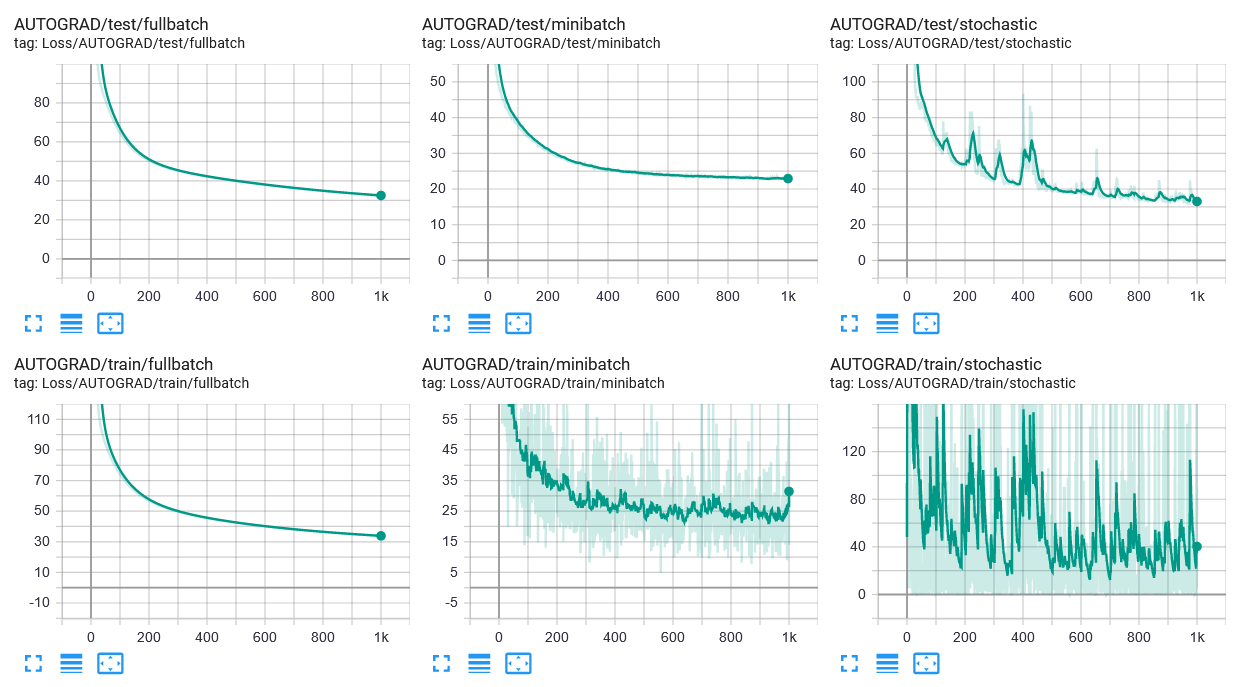

**Pour plus de clarté, on a donc choisi d'afficher la loss en train et en test *sur l'ensemble du dataset après chaque epoch de train*.**  
On utilisera également l'échelle logarithmique qui permet de mieux voir les valeurs quand on s'approche de la limite de convergence.  
Il se trouve que dans les trois cas, le coût diminue de façon claire sur la totalité des itérations :


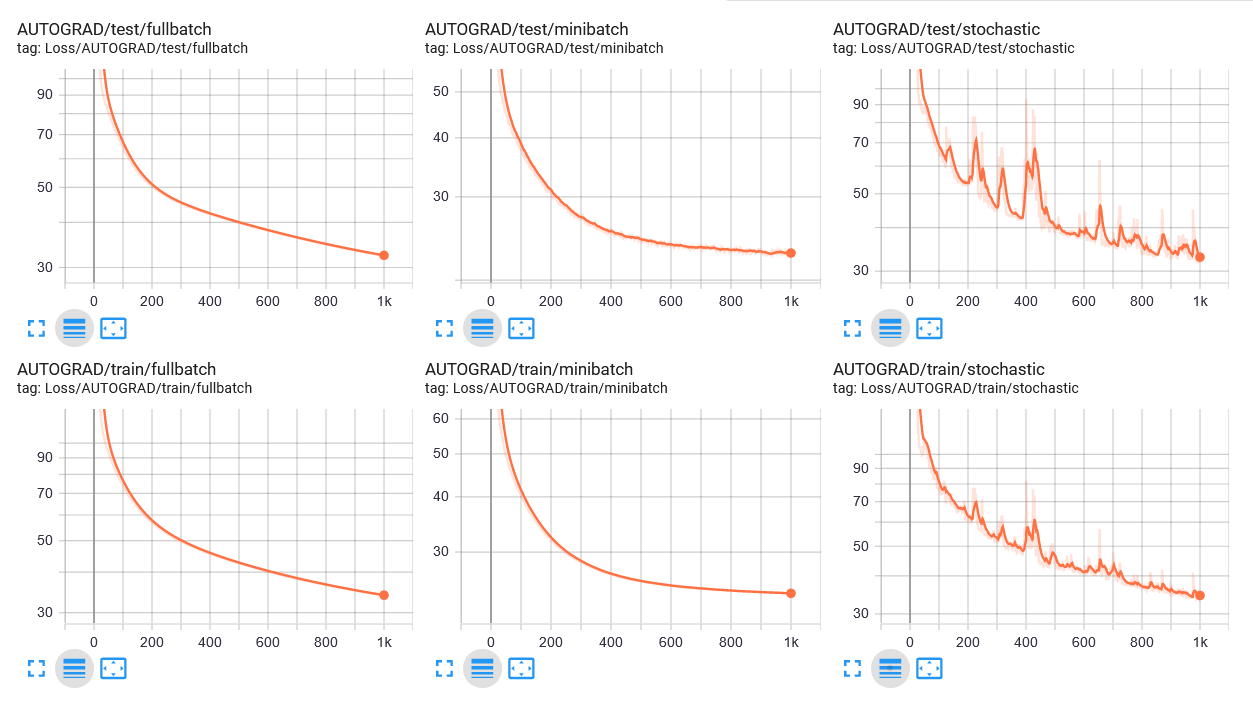


Cette situation très simple permet de se concentrer sur la comparaison entre les trois types de descente de gradient.  
On se souvient que chaque type de descente priorise différemment la durée du calcul par itération et la durée de l'apprentissage / de la convergence.  
Voyons ce qu'il en est pour ces deux critères.

**La loss décroit et converge plus vite lorsqu'on utilise des minibatchs pour faire la mise à jour.** La forme de la courbe pour le cas batch montre bien que la convergence n'a pas encore eu lieu au bout du même nombre d'itérations.   
Déjà à l'itération 100, Tensorboard affiche une losstrain = ~75 en batch contre losstrain = ~40 en minibatch. Au bout de mille itérations, l'écart reste présent avec une bien meilleure estimation du côté de minibatch. 

**La vitesse sur *chaque* itération est un autre problème.** L'apprentissage stochastique est très rapide. Sur ce petit dataset, il se fait en 766 itérations par seconde contre 389 pour la descente batch. Cependant, il ne fait qu'estimer (chaotiquement) la loss obtenue en batch sans aucun gain du point de vue de la convergence.  
L'apprentissage minibatch est le plus lent (303 it/s), car il effectue plusieurs fois le calcul à chaque itération ; mais on vient de voir qu'il permettait d'obtenir un résultat plus qualitatif.  

**Malgré ses itérations plus chronophages, la descente minibatch combine rapidité de la convergence et fiabilité de l'apprentissage. Utilisable sur de grands datasets, elle est la technique privilégiée dans le monde académique.**

L'écart de vitesse entre les types de descente serait évidemment amplifié si les données étaient plus nombreuses et plus riches.

### Utilisation d'un optimiseur <a id="opti"></a>


On ne se soucie plus de coder la mise à jour des paramètres suite à la rétropropagation : PyTorch s'en occupe pour nous avec des "optimiser steps".  
L'avantage est qu'il existe des paramètres d'optimisation divers (SGD simple, usage du momentum comme avec Adam...) et qu'il est simple de jongler entre eux.  

##### Lancement (double-clic pour dérouler l'output)

In [7]:
# ////////////////////////////////////////////////////////////////////////////// <using built-in loss functions> ////

writer = SummaryWriter()

# Hyperparameters // Learning rate 
epsilon = 0.01

# Linear GD parameters // declaring W and b as Tensors.
if xavier:
    initW = torch.empty(datatr.shape[1], etiqtr.shape[1])
    initW = torch.nn.init.xavier_normal_(initW)
else: initW = torch.randn(datatr.shape[1], etiqtr.shape[1])
initb = torch.randn(etiqtr.shape[1])

# Built-in loss
mse = torch.nn.MSELoss()

print("\n"+fbld+"------------------------------ USING A BUILT-IN OPTIMISER --------------------------------\n"+fend)

for sbatches in [datatr.shape[0],1,64]:
    rec = adminDescent(sbatches,datatr)
    
    # Reinitialising the parameters for each descent type
    # requires_grad_() is set implicitly
    W = torch.nn.Parameter(initW.detach().clone())
    b = torch.nn.Parameter(initb.detach().clone())
    
    # Built-in optimiser
    opti = torch.optim.SGD(params=[W,b],lr=epsilon)
    opti.zero_grad()
    
    # Starting to learn
    for nIter in range(1001):
        # Isolating an exemple, a mini-batch, or taking the full dataset
        inds = torch.randperm(datatr.shape[0])
        for startbatch in range(rec):
            sample = inds[startbatch*sbatches:min((startbatch+1)*sbatches,datatr.shape[0])]
            data = datatr[sample]
            etiq = etiqtr[sample]
            
            # Applying a linear transformation
            fwd = torch.nn.functional.linear(data,W.t(),b)
            loss = mse(fwd,etiq)
            # Backpropagating the gradient
            loss.backward()
            # Updating the parameters
            opti.step()
            opti.zero_grad()
            
        # Testing the current parameters
        with torch.no_grad():
            fwdtest = torch.nn.functional.linear(datats,W.t(),b)
            losstest = mse(fwdtest,etiqts)
            fwdtrain = torch.nn.functional.linear(datatr,W.t(),b)
            losstrain = mse(fwdtrain,etiqtr)
        # Saving the losses
        writer.add_scalar('Loss/OPTIMISER/train/'+transdic[sbatches],losstrain,nIter)
        writer.add_scalar('Loss/OPTIMISER/test/'+transdic[sbatches],losstest,nIter)
        
        if(nIter%100==0) and sbatches==datatr.shape[0]:
            print(f"Iterations|\t TRAIN {nIter}: loss {losstrain}")
    
    print(f"\nFinal score\t TEST: loss {losstest}")
    
print("\n"+fbld+"----------------------------- /USING A BUILT-IN OPTIMISER --------------------------------\n"+fend)
writer.close()

# ///////////////////////////////////////////////////////////////////////////// </using built-in loss functions> ////


------------------------------ USING A BUILT-IN OPTIMISER --------------------------------


//////////////////////////////////// batch descent ///////////////////////////////////////

Iterations|	 TRAIN 0: loss 498.3267822265625
Iterations|	 TRAIN 100: loss 73.78321075439453
Iterations|	 TRAIN 200: loss 56.64937210083008
Iterations|	 TRAIN 300: loss 49.51274871826172
Iterations|	 TRAIN 400: loss 45.37199020385742
Iterations|	 TRAIN 500: loss 42.38127517700195
Iterations|	 TRAIN 600: loss 40.00004577636719
Iterations|	 TRAIN 700: loss 38.030582427978516
Iterations|	 TRAIN 800: loss 36.374237060546875
Iterations|	 TRAIN 900: loss 34.96773147583008
Iterations|	 TRAIN 1000: loss 33.76475143432617

Final score	 TEST: loss 32.433372497558594

//////////////////////////////////// stochastic GD ///////////////////////////////////////

...........      Recurring 1 per epoch

Final score	 TEST: loss 32.08115768432617

////////////////////////////////// minibatch descent ///////////////////////

##### Commentaires

Visuellement, le résultat est exactement le même que précédemment. D'éventuelles différences (minimes) au niveau numérique s'expliquent par les approximations faites en interne.
On utilise donc le raccourci des optimiseurs sans problème.

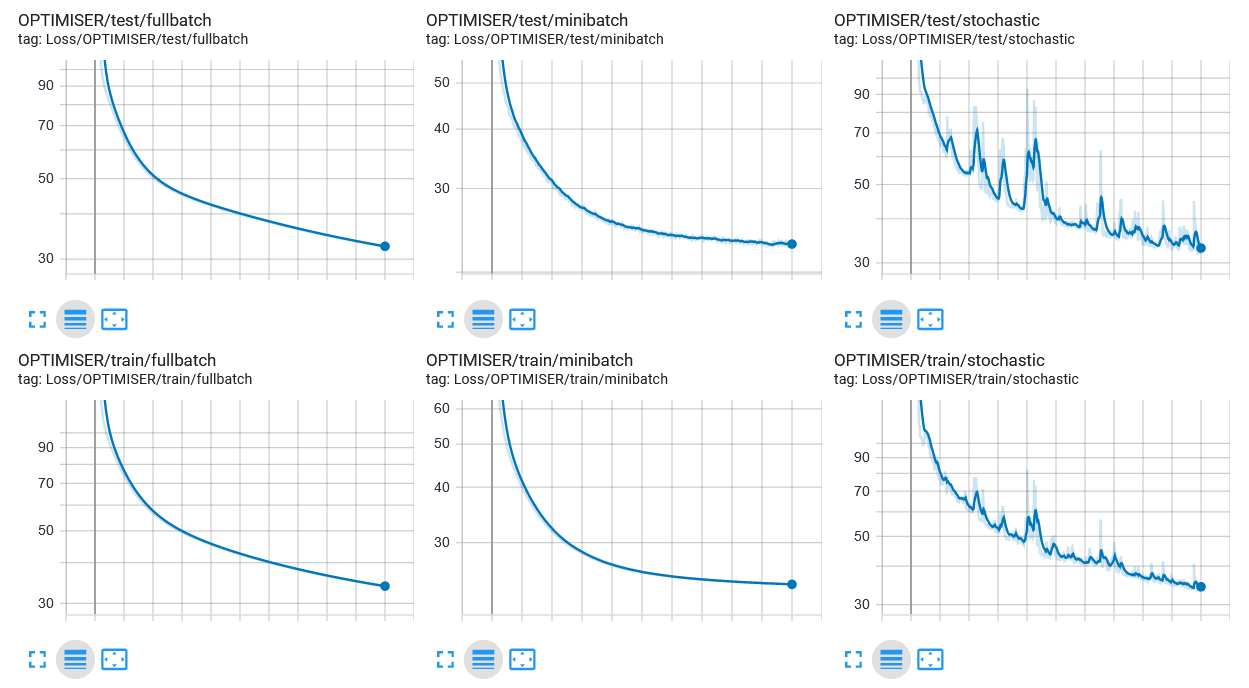

### Couches multiples et modularité <a id="layr"></a>


Les réseaux de neurones produisent des estimations plus avancées qu'une simple régression linéaire. Des résultats sémantiquement intéressants peuvent d'ailleurs être récupérés à chaque couche.  
Cependant, cette organisation en couches multiplie le nombre de paramètres, et leur gestion à la main est plus lourde.  
`torch.nn` permet de manipuler ces couches avec une typologie prédéfinie. On peut déclarer une couche linéaire et son activation, de type sigmoide, tanh, etc, et beaucoup d'autres cas. Elles sont donc faciles à échanger et leur paramétrage est très accessible.

##### Lancement (double-clic pour dérouler l'output)

On a diminué le pas de gradient à la valeur par défaut de PyTorch (0.001).

In [8]:
# ////////////////////////////////////////////////////////////////////////////////////////// <multilayer models> ////

writer = SummaryWriter()

# Hyperparameters // Learning rate 
epsilon = 0.001
# Hyperparameters // Size of the hidden layer : 1,3,10 nodes
shidden = 10

# Linear GD parameters // declaring W and b as Tensors
# Since there are two layers, we need to declare two pairs of Tensors
if xavier:
    initW1 = torch.empty(datatr.shape[1],shidden)
    initW1 = torch.nn.init.xavier_normal_(initW1)
    initW2 = torch.empty(initW1.shape[1], etiqtr.shape[1])
    initW2 = torch.nn.init.xavier_normal_(initW2)
else:
    initW1 = torch.randn(datatr.shape[1],shidden) # Random init
    initW2 = torch.randn(initW1.shape[1],etiqtr.shape[1]) # Random init
initb1 = torch.randn(shidden)
initb2 = torch.randn(etiqtr.shape[1])

# Built-in loss
mse = torch.nn.MSELoss()


print("\n"+fbld+"---------------------------------- A TWO-LAYER MODEL -------------------------------------\n"+fend)

for sbatches in [datatr.shape[0],1,64]:
    rec = adminDescent(sbatches,datatr)
    
    W1 = torch.nn.Parameter(initW1.detach().clone())
    b1 = torch.nn.Parameter(initb1.detach().clone())
    W2 = torch.nn.Parameter(initW2.detach().clone())
    b2 = torch.nn.Parameter(initb2.detach().clone())
    
    # Built-in optimiser
    opti = torch.optim.SGD(params=[W1,b1,W2,b2],lr=epsilon)
    opti.zero_grad()
            
    # Starting to learn
    for nIter in range(1001):
        # Isolating an exemple, a mini-batch, or taking the full dataset
        inds = torch.randperm(datatr.shape[0])
        for startbatch in range(rec):
            sample = inds[startbatch*sbatches:min((startbatch+1)*sbatches,datatr.shape[0])]
            data = datatr[sample]
            etiq = etiqtr[sample]
            
            # Applying linear transformations + nonlinearities
            fwd = torch.nn.functional.linear(data,W1.t(),b1)
            fwd = torch.tanh(fwd)
            fwd = torch.nn.functional.linear(fwd,W2.t(),b2)
            loss = mse(fwd,etiq)
            # Backpropagating the gradient
            loss.backward()
            # Updating the parameters
            opti.step()
            opti.zero_grad()
            
        # Testing the current parameters
        with torch.no_grad():
            fwdtest = torch.nn.functional.linear(datats,W1.t(),b1)
            fwdtest = torch.tanh(fwdtest)
            fwdtest = torch.nn.functional.linear(fwdtest,W2.t(),b2)
            losstest = mse(fwdtest,etiqts)
            fwdtrain = torch.nn.functional.linear(datatr,W1.t(),b1)
            fwdtrain = torch.tanh(fwdtrain)
            fwdtrain = torch.nn.functional.linear(fwdtrain,W2.t(),b2)
            losstrain = mse(fwdtrain,etiqtr)
        # Saving the losses
        writer.add_scalar('Loss/TWOLAYERS/train/'+transdic[sbatches],losstrain,nIter)
        writer.add_scalar('Loss/TWOLAYERS/test/'+transdic[sbatches],losstest,nIter)
        
        if(nIter%100==0) and sbatches==datatr.shape[0]:
            print(f"Iterations|\t TRAIN {nIter}: loss {losstrain}")
    
    print(f"\nFinal score\t TEST: loss {losstest}")
    
print("\n"+fbld+"--------------------------------- /A TWO-LAYER MODEL -------------------------------------\n"+fend)
writer.close()

# ///////////////////////////////////////////////////////////////////////////////////////// </multilayer models> ////


---------------------------------- A TWO-LAYER MODEL -------------------------------------


//////////////////////////////////// batch descent ///////////////////////////////////////

Iterations|	 TRAIN 0: loss 638.7655029296875
Iterations|	 TRAIN 100: loss 101.34564971923828
Iterations|	 TRAIN 200: loss 88.6546630859375
Iterations|	 TRAIN 300: loss 81.48554992675781
Iterations|	 TRAIN 400: loss 70.73005676269531
Iterations|	 TRAIN 500: loss 63.051918029785156
Iterations|	 TRAIN 600: loss 55.115631103515625
Iterations|	 TRAIN 700: loss 48.638206481933594
Iterations|	 TRAIN 800: loss 43.47737503051758
Iterations|	 TRAIN 900: loss 39.11743927001953
Iterations|	 TRAIN 1000: loss 35.492149353027344

Final score	 TEST: loss 33.53533172607422

//////////////////////////////////// stochastic GD ///////////////////////////////////////

...........      Recurring 1 per epoch

Final score	 TEST: loss 37.9585075378418

////////////////////////////////// minibatch descent ///////////////////////

##### Commentaires

**Avec deux couches et un seul noeud dans la couche cachée, la loss finale en batch augmente par rapport à précédemment**, de ~30 à ~70. Cela peut être dû à la diminution du pas de gradient, mais pas seulement : il y a plus de causes d'erreur quand les paramètres à apprendre sont multiples.  

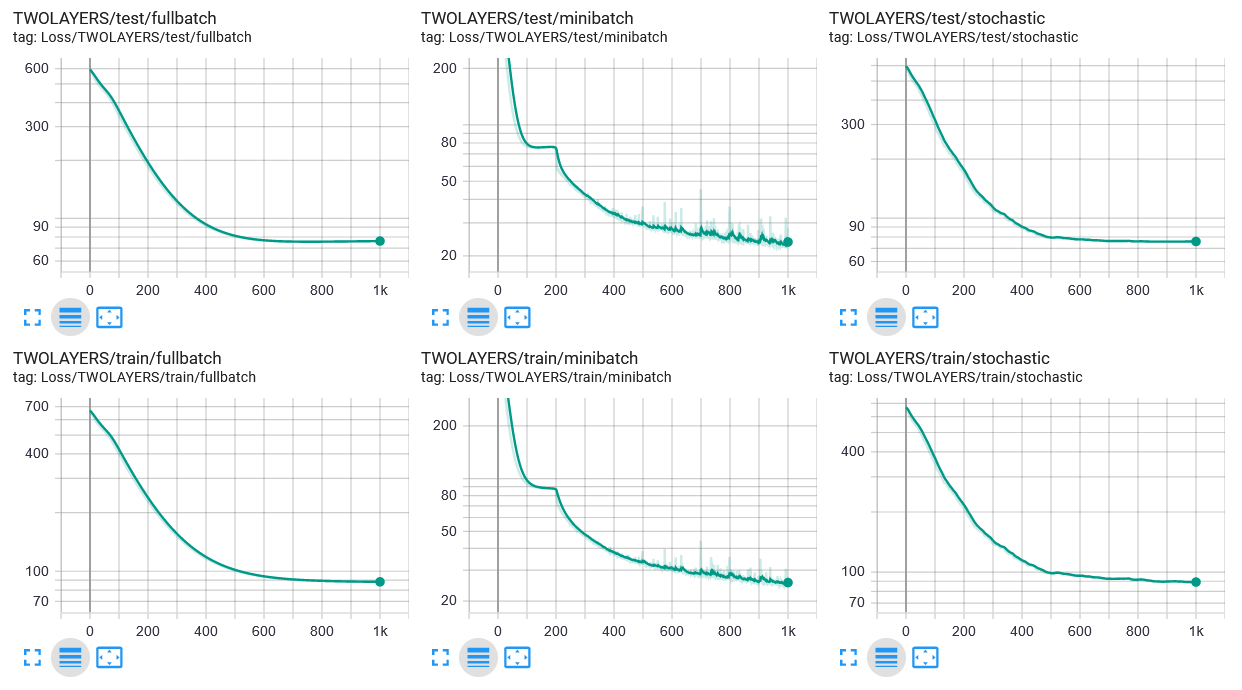


<span style="color:gray">Note : Ramenées sur l'amplitude des pas de gradient, les irrégularités de l'apprentissage stochastique sont quasi invisibles ici.</span>  

Ces résultats sont prévisibles par ailleurs. La loss en batch diminue de façon cohérente, et converge.

**En complément, un phénomène intéressant qu'on observe ici est le "décrochage" des loss** sur le cas minibatch, ici à l'itération ~200. Cela arrive apparemment quand le modèle tombe sur un minibatch qui engendre une mise à jour significative des paramètres, divisant la loss finale par deux par rapport à la descente batch. Ce minibatch spécial l'aide à dépasser un "saddle point" - une sorte de minimum local de la loss.  
On a aussi obtenu de tels décrochages avec d'autres paramètres, ainsi que pour le modèle à container SEQUENTIAL dans la section suivante. Ce n'est donc pas l'effet de ce code en particulier.

<span style="color:gray">Note : Des structures similaires sont observées quand on décroît volontairement le pas de gradient au cours de l'apprentissage, mais ce n'est pas le cas ici :  
https://stats.stackexchange.com/questions/312766/what-is-the-cause-of-the-sudden-drop-in-error-rate-that-one-often-sees-when-trai</span>

**Par contre, il n'est pas très intelligent d'utiliser une couche cachée à un seul neurone.**  
On essaie avec 3 :

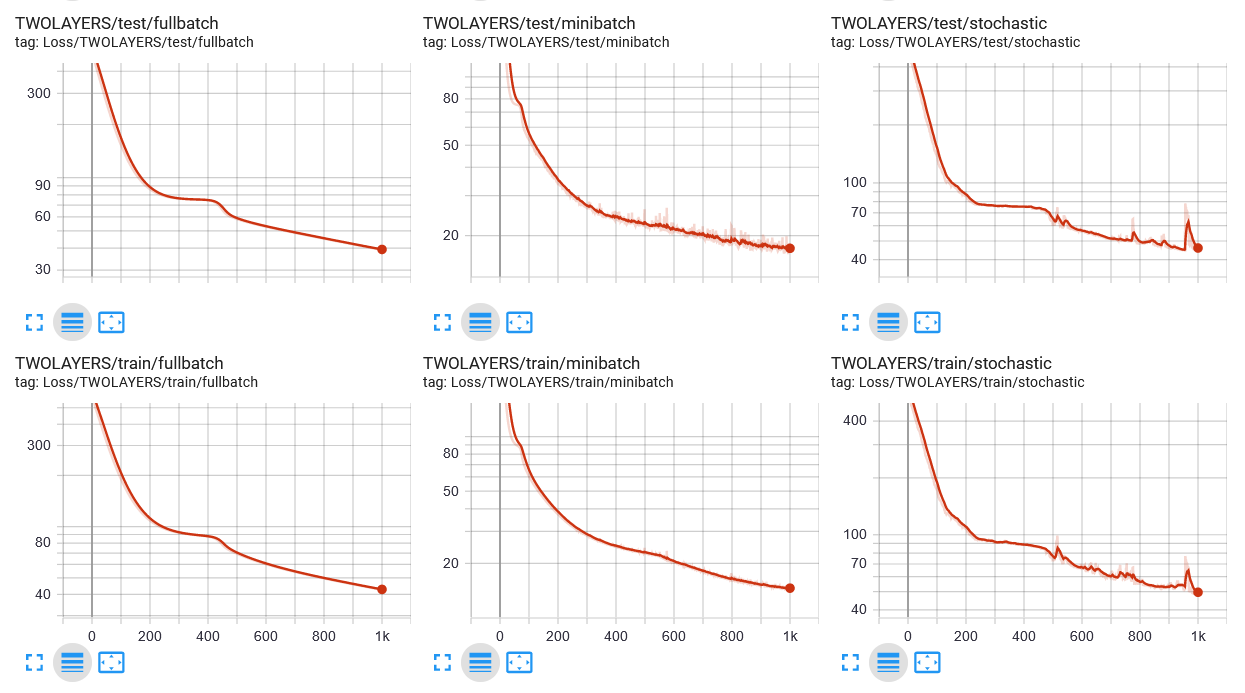



Avec 3 neurones cachés, les résultats s'améliorent en termes de loss après 1000 itérations (en batch, elle passe de ~70 à ~40 tous paramètres égaux par ailleurs). La baisse de la loss est encore plus marquante avec 10 neurones cachés :

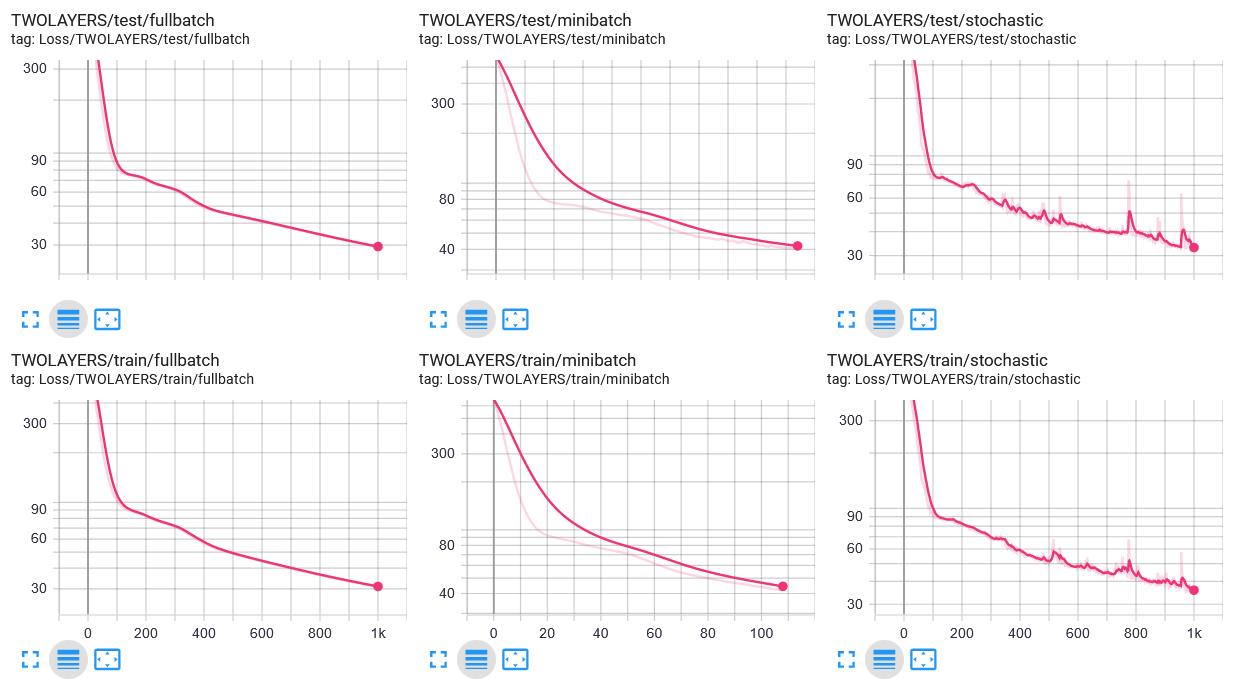

**Augmenter le nombre de neurones pour un même nombre de couches permet de faire de meilleures approximations.**  
Par contre, la forme des courbes montre que la convergence n'est pas encore atteinte au bout de 1000 itérations. On pourrait donc faire beaucoup mieux en allongeant le temps d'entraînement. En exagérant beaucoup en ce sens, on obtient effectivement des loss beaucoup plus intéressantes sur 15000 epochs (loss en test ~13 et loss en train ~9 en apprentissage batch). Cependant, on observe la structure type du surapprentissage sur le cas mini-batch : 

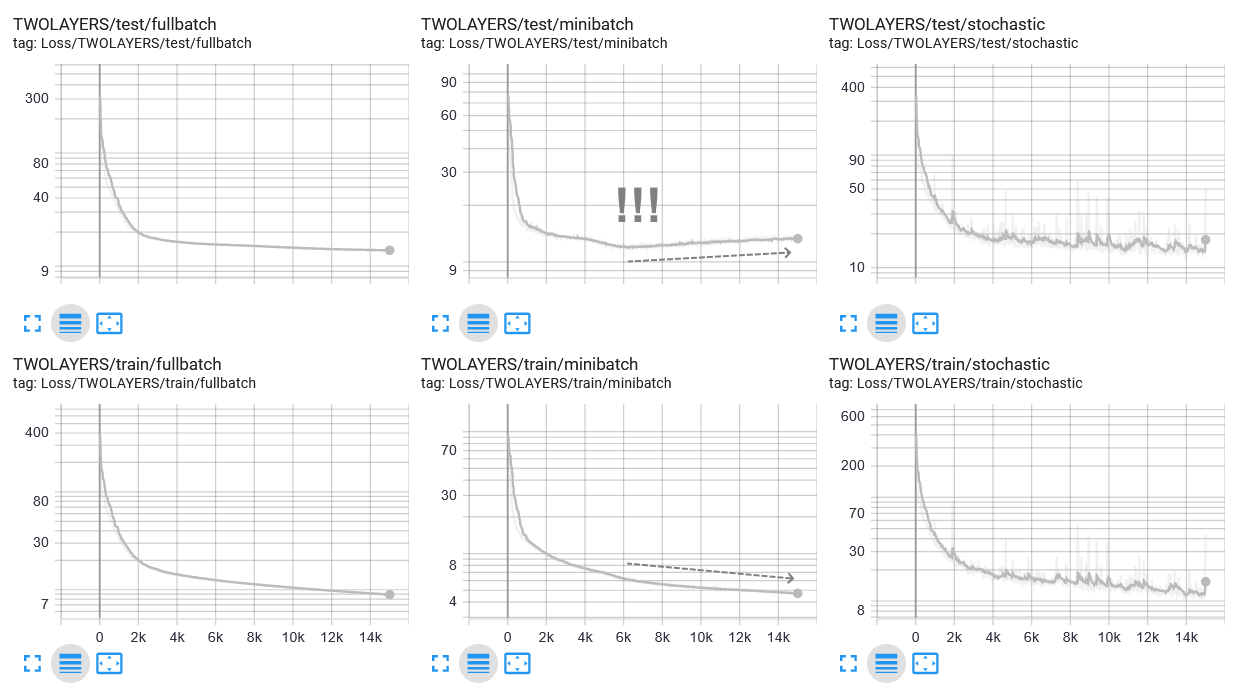

A partir de 6000 itérations, la loss en test remonte (et la loss en train contine de baisser).  
Dans un contexte réel, il faut veiller à assurer la meilleure loss possible en évitant cela à tout prix.
Solution au surapprentissage : expérimenter avec d'autres pas de gradient, ou cesser l'apprentissage plus tôt (avant 6000 itérations).



C'est assez de tests pour le moment. Il reste un dernier type de structures à explorer.

### Usage de Containers <a id="cont"></a>

Mieux encore que les fonctions de `torch.nn`, les Containers permettent de créer un modèle en spécifiant les modules inclus : il suffit de typer chaque couche, de définir une activation à la suite, et de donner sa taille.  
On voyait bien le désavantage d'avoir à déclarer des Tensors pour le biais et les poids sur des couches multiples. Le Container (ici `Sequential`) se charge de nous faire économiser quelques lignes de code ; il crée et repère automatiquement les paramètres à optimiser.

Ce repérage automatique implique aussi que toute opération explicite sur les paramètres affecte d'un coup tous les modules.


##### Lancement (double-clic pour dérouler l'output)

Pour une comparaison avec la version `torch.nn.functional`, on lance aussi sur un nombre de hiddennodes = 10 : 

In [9]:
# ////////////////////////////////////////////////////////////////////////////////////////// <using a container> ////

writer = SummaryWriter()

# Hyperparameters // Learning rate 
epsilon = 0.001
# Hyperparameters // Hidden layer size
shidden = 10 

# No more parameters, we'll just use a Sequential container.

# Built-in loss
mse = torch.nn.MSELoss()

print("\n"+fbld+"--------------------------------- PYTORCH CONTAINERS -------------------------------------\n"+fend)

for sbatches in [datatr.shape[0],1,64]:
    rec = adminDescent(sbatches,datatr)
    
    seqmodule = torch.nn.Sequential(torch.nn.Linear(datatr.shape[1],shidden),torch.nn.Tanh(),torch.nn.Linear(shidden,1))
    
    # Built-in optimiser
    opti = torch.optim.SGD(params=seqmodule.parameters(),lr=epsilon)
    opti.zero_grad()
    
    # Starting to learn
    for nIter in range(1001):
        # Isolating an exemple, a mini-batch, or taking the full dataset
        inds = torch.randperm(datatr.shape[0])
        for startbatch in range(rec):
            sample = inds[startbatch*sbatches:min((startbatch+1)*sbatches,datatr.shape[0])]
            data = datatr[sample]
            etiq = etiqtr[sample]
            
            # Applying linear transformations + non-linearities
            fwd = seqmodule(data)
            loss = mse(fwd,etiq)
            # Backpropagating the gradient
            loss.backward()
            # Updating the parameters
            opti.step()
            opti.zero_grad()
        
        # Testing the current parameters
        with torch.no_grad():
            fwdtest = seqmodule(datats)
            losstest = mse(fwdtest,etiqts)
            fwdtrain = seqmodule(datatr)
            losstrain = mse(fwdtrain,etiqtr)
        
        # Saving the losses
        writer.add_scalar('Loss/SEQMODULE/train/'+transdic[sbatches],losstrain,nIter)
        writer.add_scalar('Loss/SEQMODULE/test/'+transdic[sbatches],losstest,nIter)
        
        if(nIter%100==0) and sbatches==datatr.shape[0]:
            print(f"Iterations|\t TRAIN {nIter}: loss {losstrain}")
    
    print(f"\nFinal score\t TEST: loss {losstest}")
    
print("\n"+fbld+"-------------------------------- /PYTORCH CONTAINERS -------------------------------------\n"+fend)
writer.close()

# ///////////////////////////////////////////////////////////////////////////////////////// </using a container> ////


--------------------------------- PYTORCH CONTAINERS -------------------------------------


//////////////////////////////////// batch descent ///////////////////////////////////////

Iterations|	 TRAIN 0: loss 607.6332397460938
Iterations|	 TRAIN 100: loss 105.80145263671875
Iterations|	 TRAIN 200: loss 88.12776184082031
Iterations|	 TRAIN 300: loss 79.09152221679688
Iterations|	 TRAIN 400: loss 69.55253601074219
Iterations|	 TRAIN 500: loss 61.075157165527344
Iterations|	 TRAIN 600: loss 54.92545700073242
Iterations|	 TRAIN 700: loss 49.17937469482422
Iterations|	 TRAIN 800: loss 43.64338684082031
Iterations|	 TRAIN 900: loss 39.01277160644531
Iterations|	 TRAIN 1000: loss 35.26875686645508

Final score	 TEST: loss 32.82851791381836

//////////////////////////////////// stochastic GD ///////////////////////////////////////

...........      Recurring 1 per epoch

Final score	 TEST: loss 36.08015823364258

////////////////////////////////// minibatch descent ////////////////////////

##### Commentaires

Le visuel est familier. Rien de particulier à commenter.  
Les valeurs ne sont pas *exactement* les mêmes qu'auparavant, car l'initialisation par défaut des paramètres des couches du Container n'est pas de type Xavier.

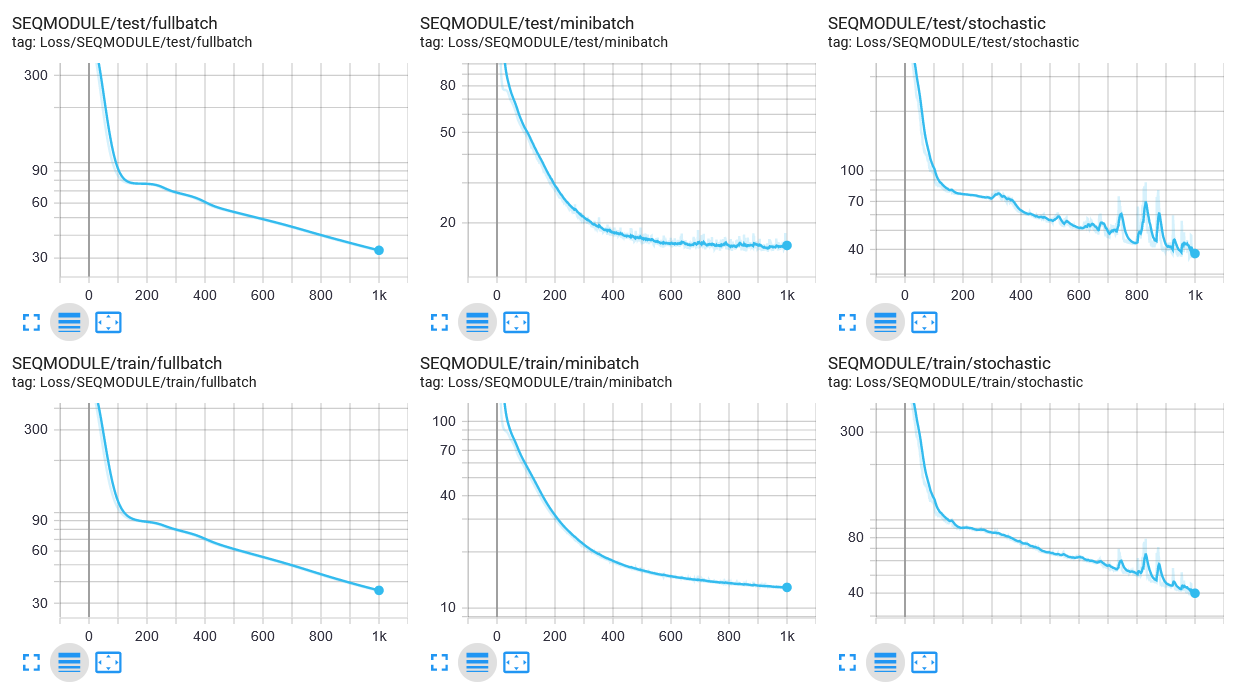

Si l'on tient à avoir les mêmes résultats, on peut changer le type d'initialisation en passant une fonction de remplissage sur les éléments du Container (pas de modification directe possible).

Cela a d'ailleurs d'autres intérêts. Comme quelqu'un le dit sur ce fil :  
https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

> The default initialization doesn't always give the best results, though. I recently implemented the VGG16 architecture in Pytorch and trained it on the CIFAR-10 dataset, and I found that just by switching to xavier_uniform initialization for the weights (with biases initialized to 0), rather than using the default initialization, my validation accuracy after 30 epochs of RMSprop increased from 82% to 86%. I also got 86% validation accuracy when using Pytorch's built-in VGG16 model (not pre-trained), so I think I implemented it correctly. (...)

On garde donc la fonction suivante en tête.

In [10]:
# ///////////////////////////////////////////////////////////////////////////////////////////// <parameter init> ////

def initWeights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        # a very small bias init (although it shouldn't be null) helps as well
        m.bias.data.fill_(0.01)

# to use this: create a net = torch.nn.Sequential(...), then net.apply(initWeights)

# //////////////////////////////////////////////////////////////////////////////////////////// </parameter init> ////

Un mot sur les types de Containers, selon la documentation :

> `Sequential` : plugs layers in a feed-forward fully connected manner ;  
> `Parallel` : applies its ith child module to the ith slice of the input Tensor ;  
> `Concat` : concatenates in one layer several modules along dimension `dim` ;  
> `DepthConcat` : like `Concat`, but adds zero-padding when non-`dim` sizes don't match.

Pour un problème très basique, le Container qui nous va est `Sequential`. On voit mal l'intérêt d'utiliser les autres sur une base telle que Boston Housing (aussi réduite en caractéristiques et en nombre d'enregistrements), d'autant plus qu'elle n'est initialement faite que pour de simples régressions.  
`Parallel` par exemple aurait été intéressant si les caractéristiques des données étaient sémantiquement plus complexes et requéraient des traitements séparés pour avoir un output plus juste.  
Nous aurons l'occasion d'explorer ces autres cas plus tard.

### Conclusions

Ce TME a permis d'expérimenter les fonctions automatiques de PyTorch.  
Ayant compris le fonctionnement d'Autograd et des optimiseurs intégrés, on les utilisera implicitement dans les TME suivants.  

On aura généralement le choix à l'avenir entre déclarer des Modules séparés et les chaîner, ou utiliser directement un Container (qui les encapsule ensemble). Tout dépendra de l'objectif exact.  
La semaine prochaine, nous créerons notre premier modèle complexe.